# **<a id="Content">HnM RecSys Notebook 9417</a>**

## **<a id="Content">Table of Contents</a>**
* [**<span>1. Imports</span>**](#Imports)  
* [**<span>2. Pre-Processing</span>**](#Pre-Processing)
* [**<span>3. Exploratory Data Analysis</span>**](#Exploratory%20Data%20Analysis)  
    * [**<span>3.1 Articles</span>**](#EDA::Articles)  
    * [**<span>3.2 Customers</span>**](#EDA::Customers)
    * [**<span>3.3 Transactions</span>**](#EDA::Transactions)
* [**<span>4. Models</span>**](#Models) 
    * [**<span>4.1 Popularity</span>**](#Popularity%20Model)   
    * [**<span>4.2 ALS</span>**](#Alternating%20Least%20Squares)  
    * [**<span>4.2 GBDT</span>**](#GBDT)  
    * [**<span>4.3 SGD/similar</span>**](#SGD)  
    * [**<span>4.4 NN</span>**](#NN)  



## Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import re
import warnings
# import cudf # switch on P100 GPU for this to work
# import cupy as cp

# Importing data
articles = pd.read_csv('articles.csv')
print(articles.head())
print("--")
customers = pd.read_csv('customers.csv')
print(customers.head())
print("--")
transactions = pd.read_csv("transactions_train.csv")
print(transactions.head())
print("--")

   article_id  product_code          prod_name  product_type_no   
0   108775015        108775          Strap top              253  \
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no   
0          Vest top  Garment Upper body                  1010016  \
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...   
0                     Solid                  9             Black  ...  \
1                     Solid               

## Pre-Processing

In [36]:
# ----- empty value stats -------------
print("Missing values: ")
print(customers.isnull().sum())
print("--\n")

print("FN Newsletter vals: ", customers['FN'].unique())
print("Active communication vals: ",customers['Active'].unique())
print("Club member status vals: ", customers['club_member_status'].unique())
print("Fashion News frequency vals: ", customers['fashion_news_frequency'].unique())
print("--\n")

# ---- data cleaning -------------

customers['FN'] = customers['FN'].fillna(0)
customers['Active'] = customers['Active'].fillna(0)

# replace club_member_status missing values with 'LEFT CLUB' --> no members with LEFT CLUB status in data
customers['club_member_status'] = customers['club_member_status'].fillna('LEFT CLUB')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('NONE', 'None')
customers['age'] = customers['age'].fillna(customers['age'].mean())
customers['age'] = customers['age'].astype(int)
articles['detail_desc'] = articles['detail_desc'].fillna('None')

print("Missing values: ")
print(customers.isnull().sum())
print("--\n")


# ---- memory optimizations -------------

# uses 8 bytes instead of given 64 byte string, reduces mem by 8x, 
# !!!! have to convert back before merging w/ sample_submissions.csv
transactions['customer_id'] = transactions['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
# uses 4 bytes instead of given 10 byte string, reduces mem by 2.5x
transactions['article_id'] = transactions['article_id'].astype('int32') 
# !!!! ADD LEADING ZERO BACK BEFORE SUBMISSION OF PREDICTIONS TO KAGGLE: 
#transactions['article_id'] = '0' + transactions.article_id.astype('str')

# reduces mem by 3x
transactions['price'] = transactions['price'].astype('float32') 
transactions['sales_channel_id'] = transactions['sales_channel_id'].astype('int8')

Missing values: 
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64
--

FN Newsletter vals:  [nan  1.]
Active communication vals:  [nan  1.]
Club member status vals:  ['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']
Fashion News frequency vals:  ['NONE' 'Regularly' nan 'Monthly']
--

Missing values: 
customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64
--



## <a id="Exploratory Data Analysis">Exploratory Data Analysis</a>

### EDA::Articles

<b>Article data:</b>

`article_id` : Unique id for every article of clothing<br>

Observing the structure of the column info, this indentation structure of features satisfied article identification: <br>

- `<index_group_no>` and `<index_group_name>` :: <b>(clothing categories)</b>
	- `<index_name>` and `<index_group_no>` :: <b>(clothing categories' sub-groups) -- same as index group if no subgroups for a category</b>
		- `<section_name>` and `<section_no>` :: <b>(clothing collections)</b>
			- `<garment_group_name>` and `<garment_group_no>` :: <b>(garment groups)</b>
				- `<product_group_name>` and `<product_group_no>` :: <b>(product groups)</b>
					- `<product_type_name>` and `<prod_type_no>` :: <b>(product types)</b>
						- `<product_code>` and `<prod_name>` :: <b>(product names)</b>

Other data: <br>
`colour_*`: colour info of each article                    
`perceived_colour_*`: colour info of each article<br>
`department_*`: department info<br>
`detail_desc`: article description<br>
(we're ignoring `graphical_*` features since we are not going to use the image data)


In [37]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


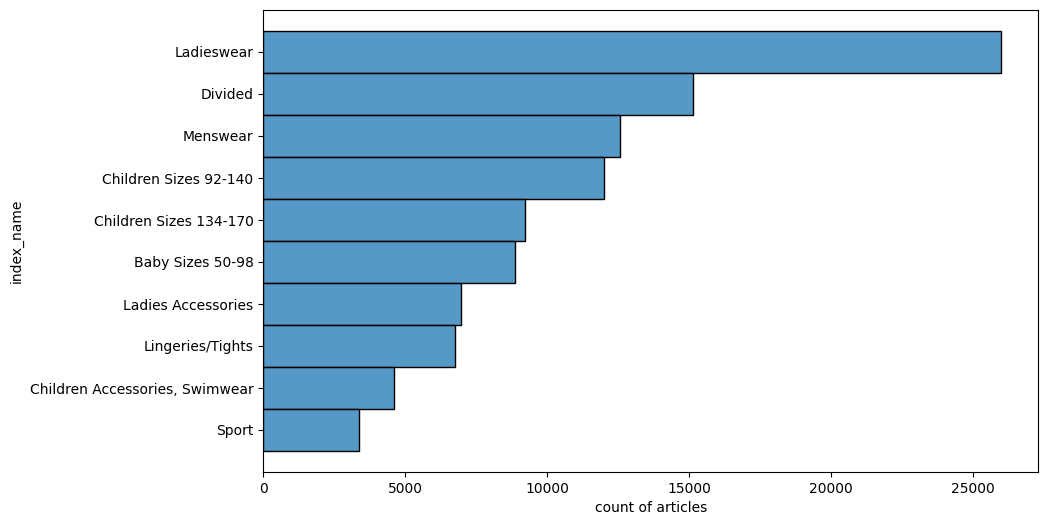

In [38]:
# Observing the most popular clothing categories (indices)

# Convert index_name to ordered categorical for ordered histplot
ordered_index_names = articles['index_name'].value_counts().index
articles['index_name'] = pd.Categorical(articles['index_name'], categories=ordered_index_names, ordered=True)

# Plot histogram
f, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=articles, y='index_name')
ax.set_xlabel('count of articles')
ax.set_ylabel('index_name')
plt.show()

The Ladieswear category and Children (aggregated) category have the most articles. The Sport category has the least articles.

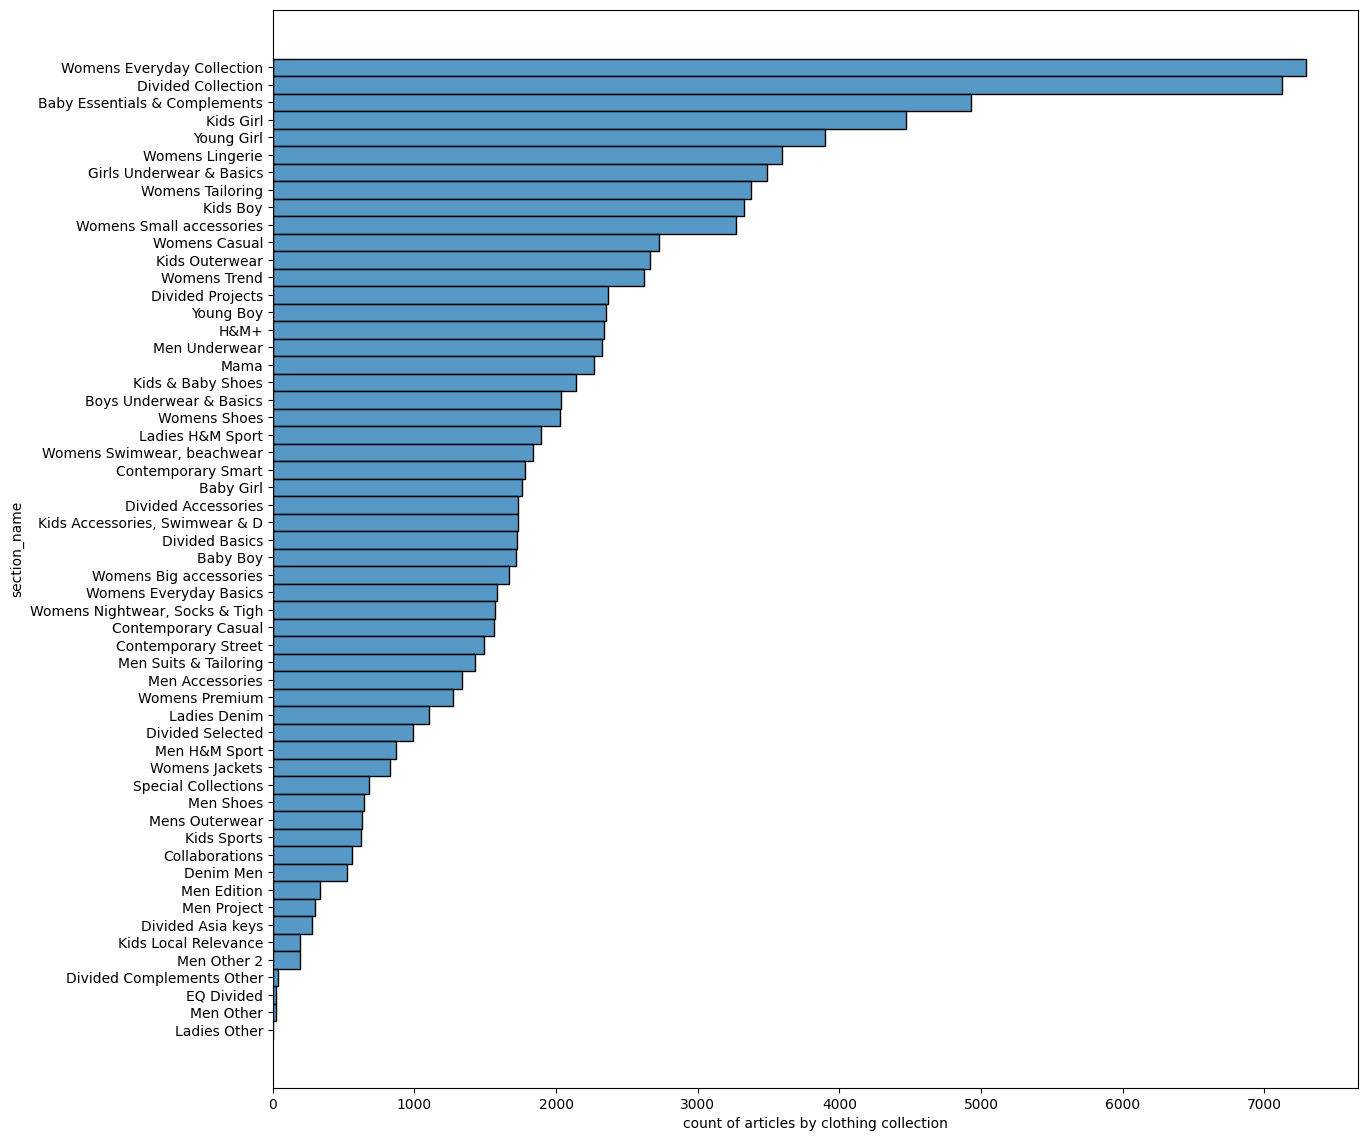

In [39]:
# Observing the most popular clothing collections (sections)

ordered_section_names = articles['section_name'].value_counts().index
articles['section_name'] = pd.Categorical(articles['section_name'], categories=ordered_section_names, ordered=True)

f, ax = plt.subplots(figsize=(14, 14))
sns.histplot(data=articles, y='section_name', bins=len(ordered_section_names))
ax.set_xlabel('count of articles by clothing collection')
ax.set_ylabel('section_name')
plt.show()

Women's Everyday Collection, followed by the miscellaneous section Divided Collection, and Baby Essentials & Complements.
Ladies Other has the least number of articles.

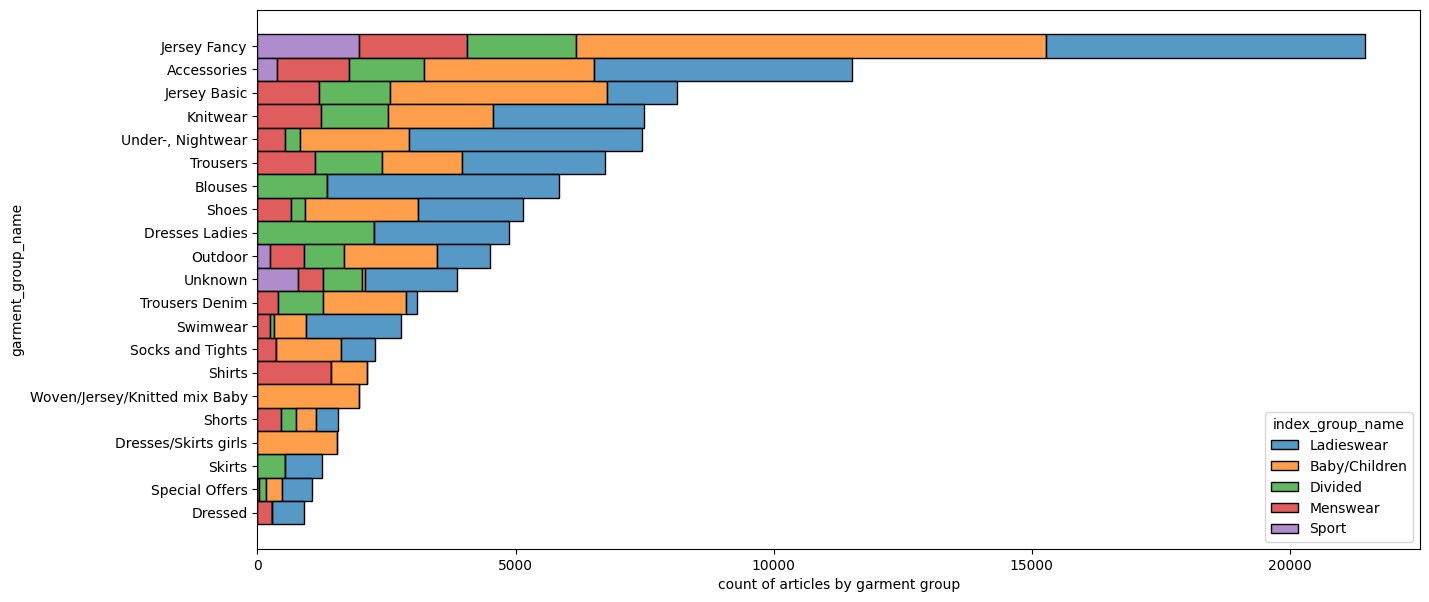

In [40]:
# Observing garments grouped by their clothing category (index_group)

ordered_garment_group_names = articles['garment_group_name'].value_counts().index
ordered_index_group_names = articles['index_group_name'].value_counts().index
articles['garment_group_name'] = pd.Categorical(articles['garment_group_name'], categories=ordered_garment_group_names, ordered=True)
articles['index_group_name'] = pd.Categorical(articles['index_group_name'], categories=ordered_index_group_names, ordered=True)

f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', hue='index_group_name', multiple="stack")
ax.set_xlabel('count of articles by garment group')
ax.set_ylabel('garment_group_name')
plt.show()


Jersey Fancy and Accessories are the most popular garment groups; a large part of the Ladieswear and Children categories contribute to the garment group counts.

In [41]:
# Observing number of articles per clothing category

articles.groupby(['index_group_name']).count()['article_id']

index_group_name
Ladieswear       39737
Baby/Children    34711
Divided          15149
Menswear         12553
Sport             3392
Name: article_id, dtype: int64

In [42]:
# Since some clothing categories (index_group_name) have sub-categories (index_name):
# Observing number of articles per sub-category

grouped_counts = articles.groupby(['index_group_name', 'index_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

index_group_name  index_name                    
Ladieswear        Ladieswear                        26001
                  Ladies Accessories                 6961
                  Lingeries/Tights                   6775
Baby/Children     Children Sizes 92-140             12007
                  Children Sizes 134-170             9214
                  Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
Divided           Divided                           15149
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

The clothing sub-catgeory of Ladieswear in the Ladieswear category has the most articles.<br>
The clothing sub-catgeory of Children Sizes 92-140 in the Baby/Children category has the most articles in the category.

In [43]:
# Observing number of articles by product group
grouped_counts = articles.groupby(['garment_group_name', 'product_group_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

garment_group_name  product_group_name
Jersey Fancy        Accessories              43
                    Garment Full body      3384
                    Garment Lower body     3179
                    Garment Upper body    14356
                    Nightwear                82
                                          ...  
Special Offers      Swimwear                  8
                    Underwear                 7
Dressed             Garment Full body         2
                    Garment Upper body      905
                    Unknown                   1
Name: article_id, Length: 121, dtype: int64

In [44]:
# Observing number of articles by product groups

grouped_counts = articles.groupby(['product_group_name', 'product_type_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

product_group_name   product_type_name
Accessories          Accessories set         7
                     Alice band              6
                     Baby Bib                3
                     Bag                  1280
                     Beanie                 56
                                          ... 
Underwear            Underwear corset        7
                     Underwear set          47
Underwear/nightwear  Sleep Bag               6
                     Sleeping sack          48
Unknown              Unknown               121
Name: article_id, Length: 132, dtype: int64

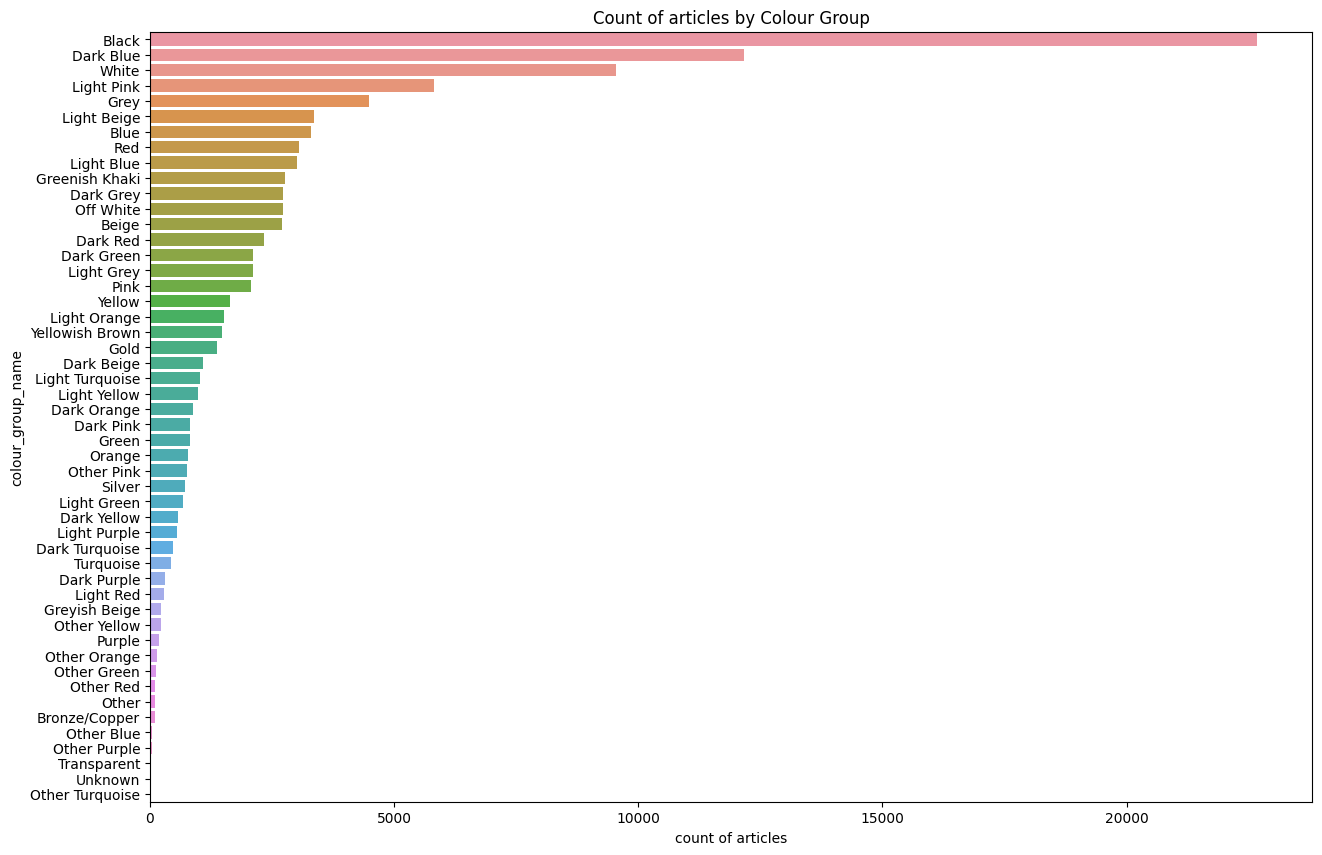

In [45]:
# Observing the most popular colours for articles

ordered_colour_names = articles['colour_group_name'].value_counts().index
articles['colour_group_name'] = pd.Categorical(articles['colour_group_name'], categories=ordered_colour_names, ordered=True)

f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='colour_group_name', data=articles, order=ordered_colour_names)
ax.set_xlabel('count of articles')
ax.set_ylabel('colour_group_name')
ax.set_title('Count of articles by Colour Group')
plt.show()

Black, dark blue and white are the most popular colours overall.

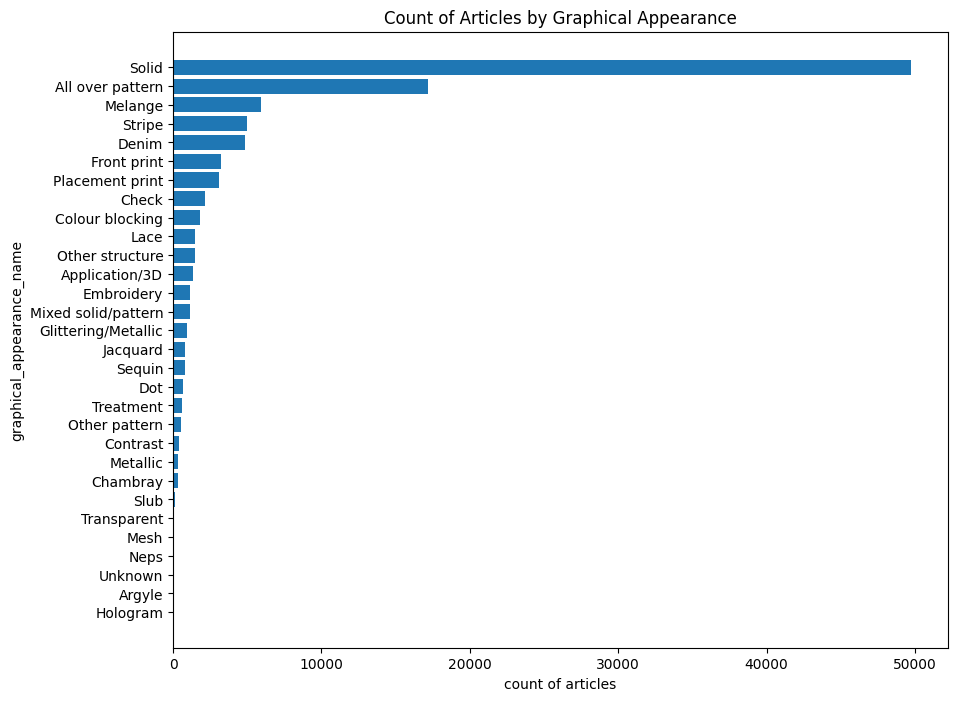

In [46]:
# Observing the most popular graphics for articles

count_by_graphical_appearance = articles['graphical_appearance_name'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(count_by_graphical_appearance.index, count_by_graphical_appearance.values)
ax.set_title('Count of Articles by Graphical Appearance')
ax.set_xlabel('count of articles')
ax.set_ylabel('graphical_appearance_name')
plt.show()

A Solid pattern on articles is most popular.

### EDA::Customers

<b>Customer data:</b>

`customer_id` : Unique id for every customer<br>
`FN` (Does the customer receive fashion news): 1 or 0 <br>
`Active` (Is the customer active for communication): 1 or 0<br>
`club_member_status` (Customer's club status): 'ACTIVE' or 'PRE-CREATE' or 'LEFT CLUB'<br>
`fashion_news_frequency` (How often H&M may send news to customer): 'Regularly' or 'Monthly' or 'None'<br>
`age` : Customer's age<br>
`postal_code` : Customer's postal code<br>

In [47]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0000,0.0000,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0000,0.0000,ACTIVE,None,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0000,0.0000,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0000,0.0000,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0000,1.0000,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [48]:
# Observing postal code counts

top_5_postal_codes = customers['postal_code'].value_counts().head(5)
print(top_5_postal_codes)

postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
Name: count, dtype: int64


Clearly, the most common postal code is either some default postal code or a centralized delivery location.

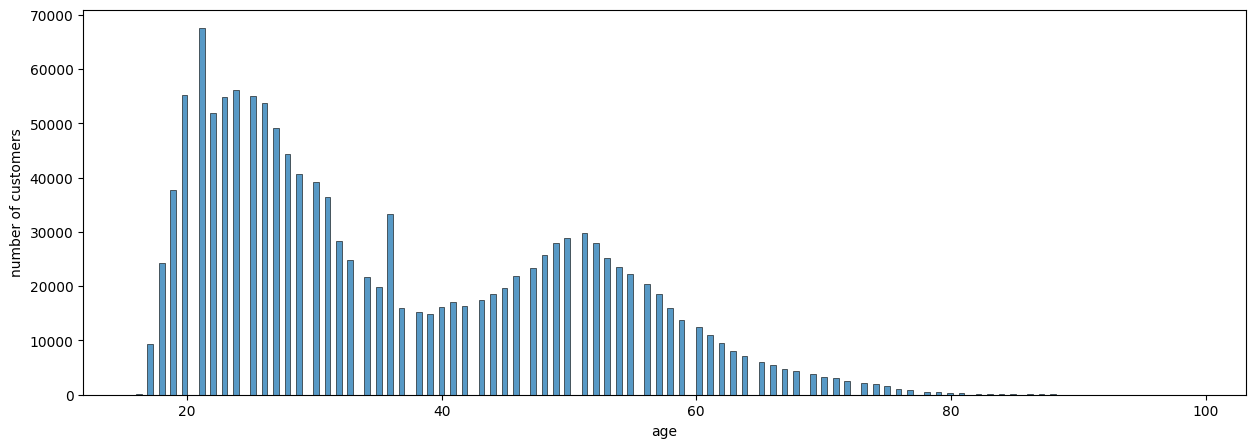

In [49]:
# Observing the customer age distribution

f, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=customers, x='age')
ax.set_ylabel('number of customers')
plt.show()

In [50]:
top_5_ages = customers['age'].value_counts().head(5)
print(top_5_ages)

age
21    67530
24    56124
20    55196
25    54989
23    54867
Name: count, dtype: int64


Clearly, the age range of 20-25 has the most customers.

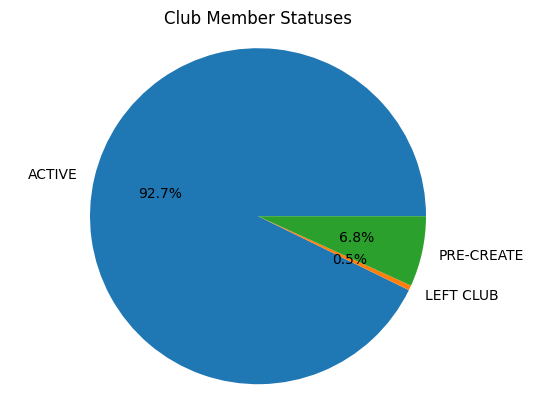

In [51]:
# Observing the club member status of customers

# Group the customers by club member status and count the number of customers in each group
club_member_counts = customers.groupby('club_member_status')['customer_id'].count()

# Pie chart
plt.pie(club_member_counts.values, labels=club_member_counts.index, autopct='%1.1f%%')
plt.title('Club Member Statuses')
plt.axis('equal')
plt.show()

An overwhelming majority of customers currently have an active club status.

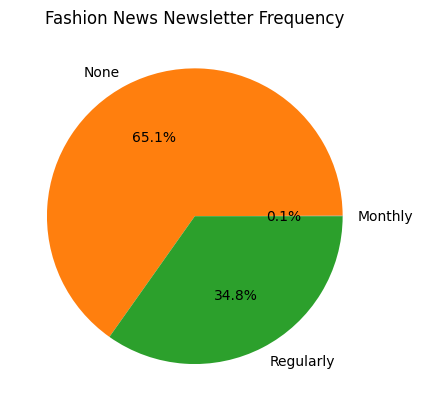

In [52]:
# Observing the FN subscription of customers

news_frequency_counts = customers.groupby('fashion_news_frequency')['customer_id'].count()

# create a pie chart
plt.pie(news_frequency_counts, labels=news_frequency_counts.index, autopct='%1.1f%%')
plt.title('Fashion News Newsletter Frequency')
plt.show()

A majority of customers don't subsribe to the fashion newsletter.

### EDA::Transactions

<b>Transaction data:</b>

`t_dat`: date the transaction occured in yyyy-mm-dd format <br>
`customer_id`: in customers df <br>
`article_id` in articles df <br>
`price`: geneneralized price (not a currency or unit) <br>
`sales_channel_id`: 1 = in-store or 2 = online <br>

In [53]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,663713001,0.0508,2
1,2018-09-20,-6846340800584936,541518023,0.0305,2
2,2018-09-20,-8334631767138808638,505221004,0.0152,2
3,2018-09-20,-8334631767138808638,685687003,0.0169,2
4,2018-09-20,-8334631767138808638,685687004,0.0169,2


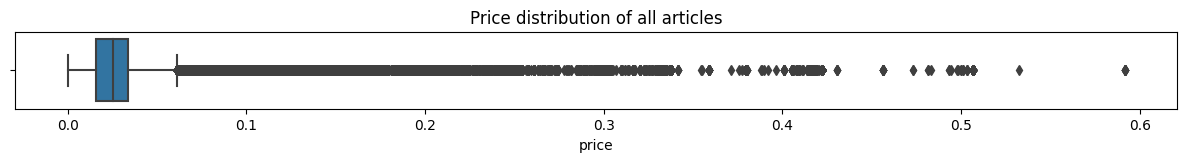

count   31788324.0000
mean           0.0278
std            0.0192
min            0.0000
25%            0.0158
50%            0.0254
75%            0.0339
max            0.5915
Name: price, dtype: float64

In [54]:
f, ax = plt.subplots(figsize=(15,1))
ax.set_title('Price distribution of all articles')
sns.boxplot(x='price', data=transactions)
plt.show()
pd.set_option('display.float_format', '{:.4f}'.format)
transactions.describe()['price']

The prices seem to vary a lot across all articles, so the above plot doesn't give us useful information. <br>
The total transaction count is ~31 million, so we'll use a 100,000 sample from the transaction data as needed.

In [55]:
# merging transactions and artciles df on aritcle_id

articles_product_columns = articles[['article_id', 'index_name', 'product_group_name', 'product_type_name', 'prod_name']]
# merged_table_ta --> merged_table_transactions_articles
merged_table_ta = transactions[['customer_id', 'article_id', 'price', 'sales_channel_id','t_dat']].merge(articles_product_columns, on='article_id', how='left')


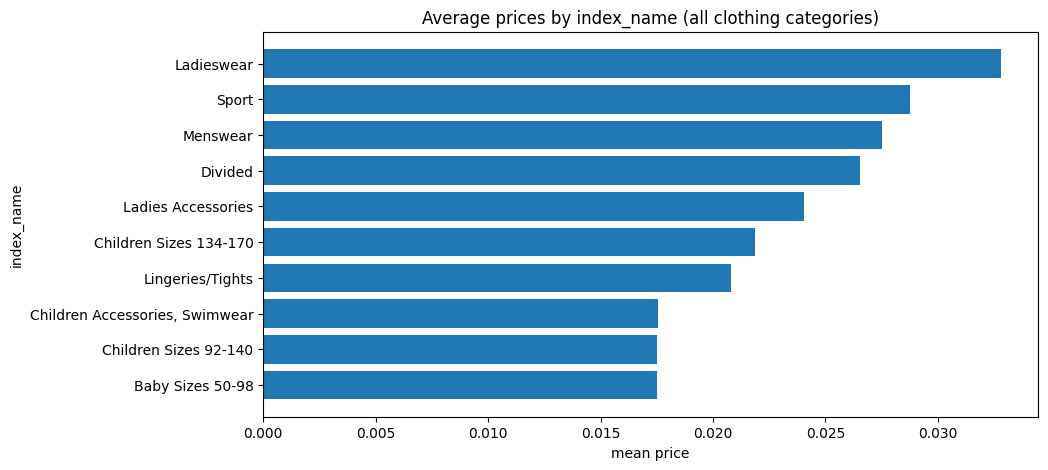

In [56]:
# Observing the mean price of each sub-clothing catgeory (index_name)

# Group the data by index_name and calculate the mean price for each group
price_by_index_name = merged_table_ta.groupby('index_name')['price'].mean()
price_by_index_name = price_by_index_name.sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(price_by_index_name.index, price_by_index_name.values)
ax.set_title('Average prices by index_name (all clothing categories)')
ax.set_xlabel('mean price')
ax.set_ylabel('index_name')
plt.show()

The Ladieswear sub-category in the Ladieswear category has the largest mean price.

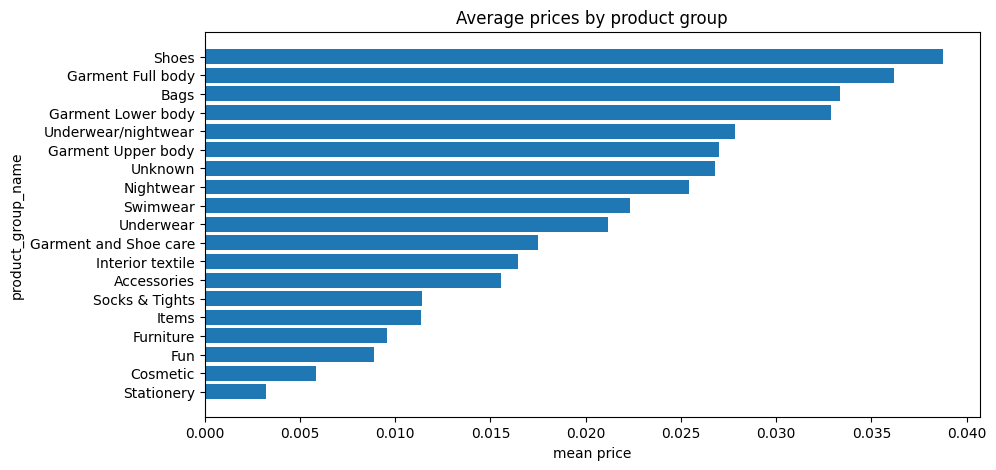

In [57]:
# Observing the mean price of each product group

# Group the data by product_group_name and calculate the mean price for each group
price_by_product_group = merged_table_ta[['product_group_name', 'price']].groupby('product_group_name').mean()
price_by_product_group = price_by_product_group.sort_values(by='price', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(price_by_product_group.index, price_by_product_group['price'])
ax.set_title('Average prices by product group')
ax.set_xlabel('mean price')
ax.set_ylabel('product_group_name')
plt.show()

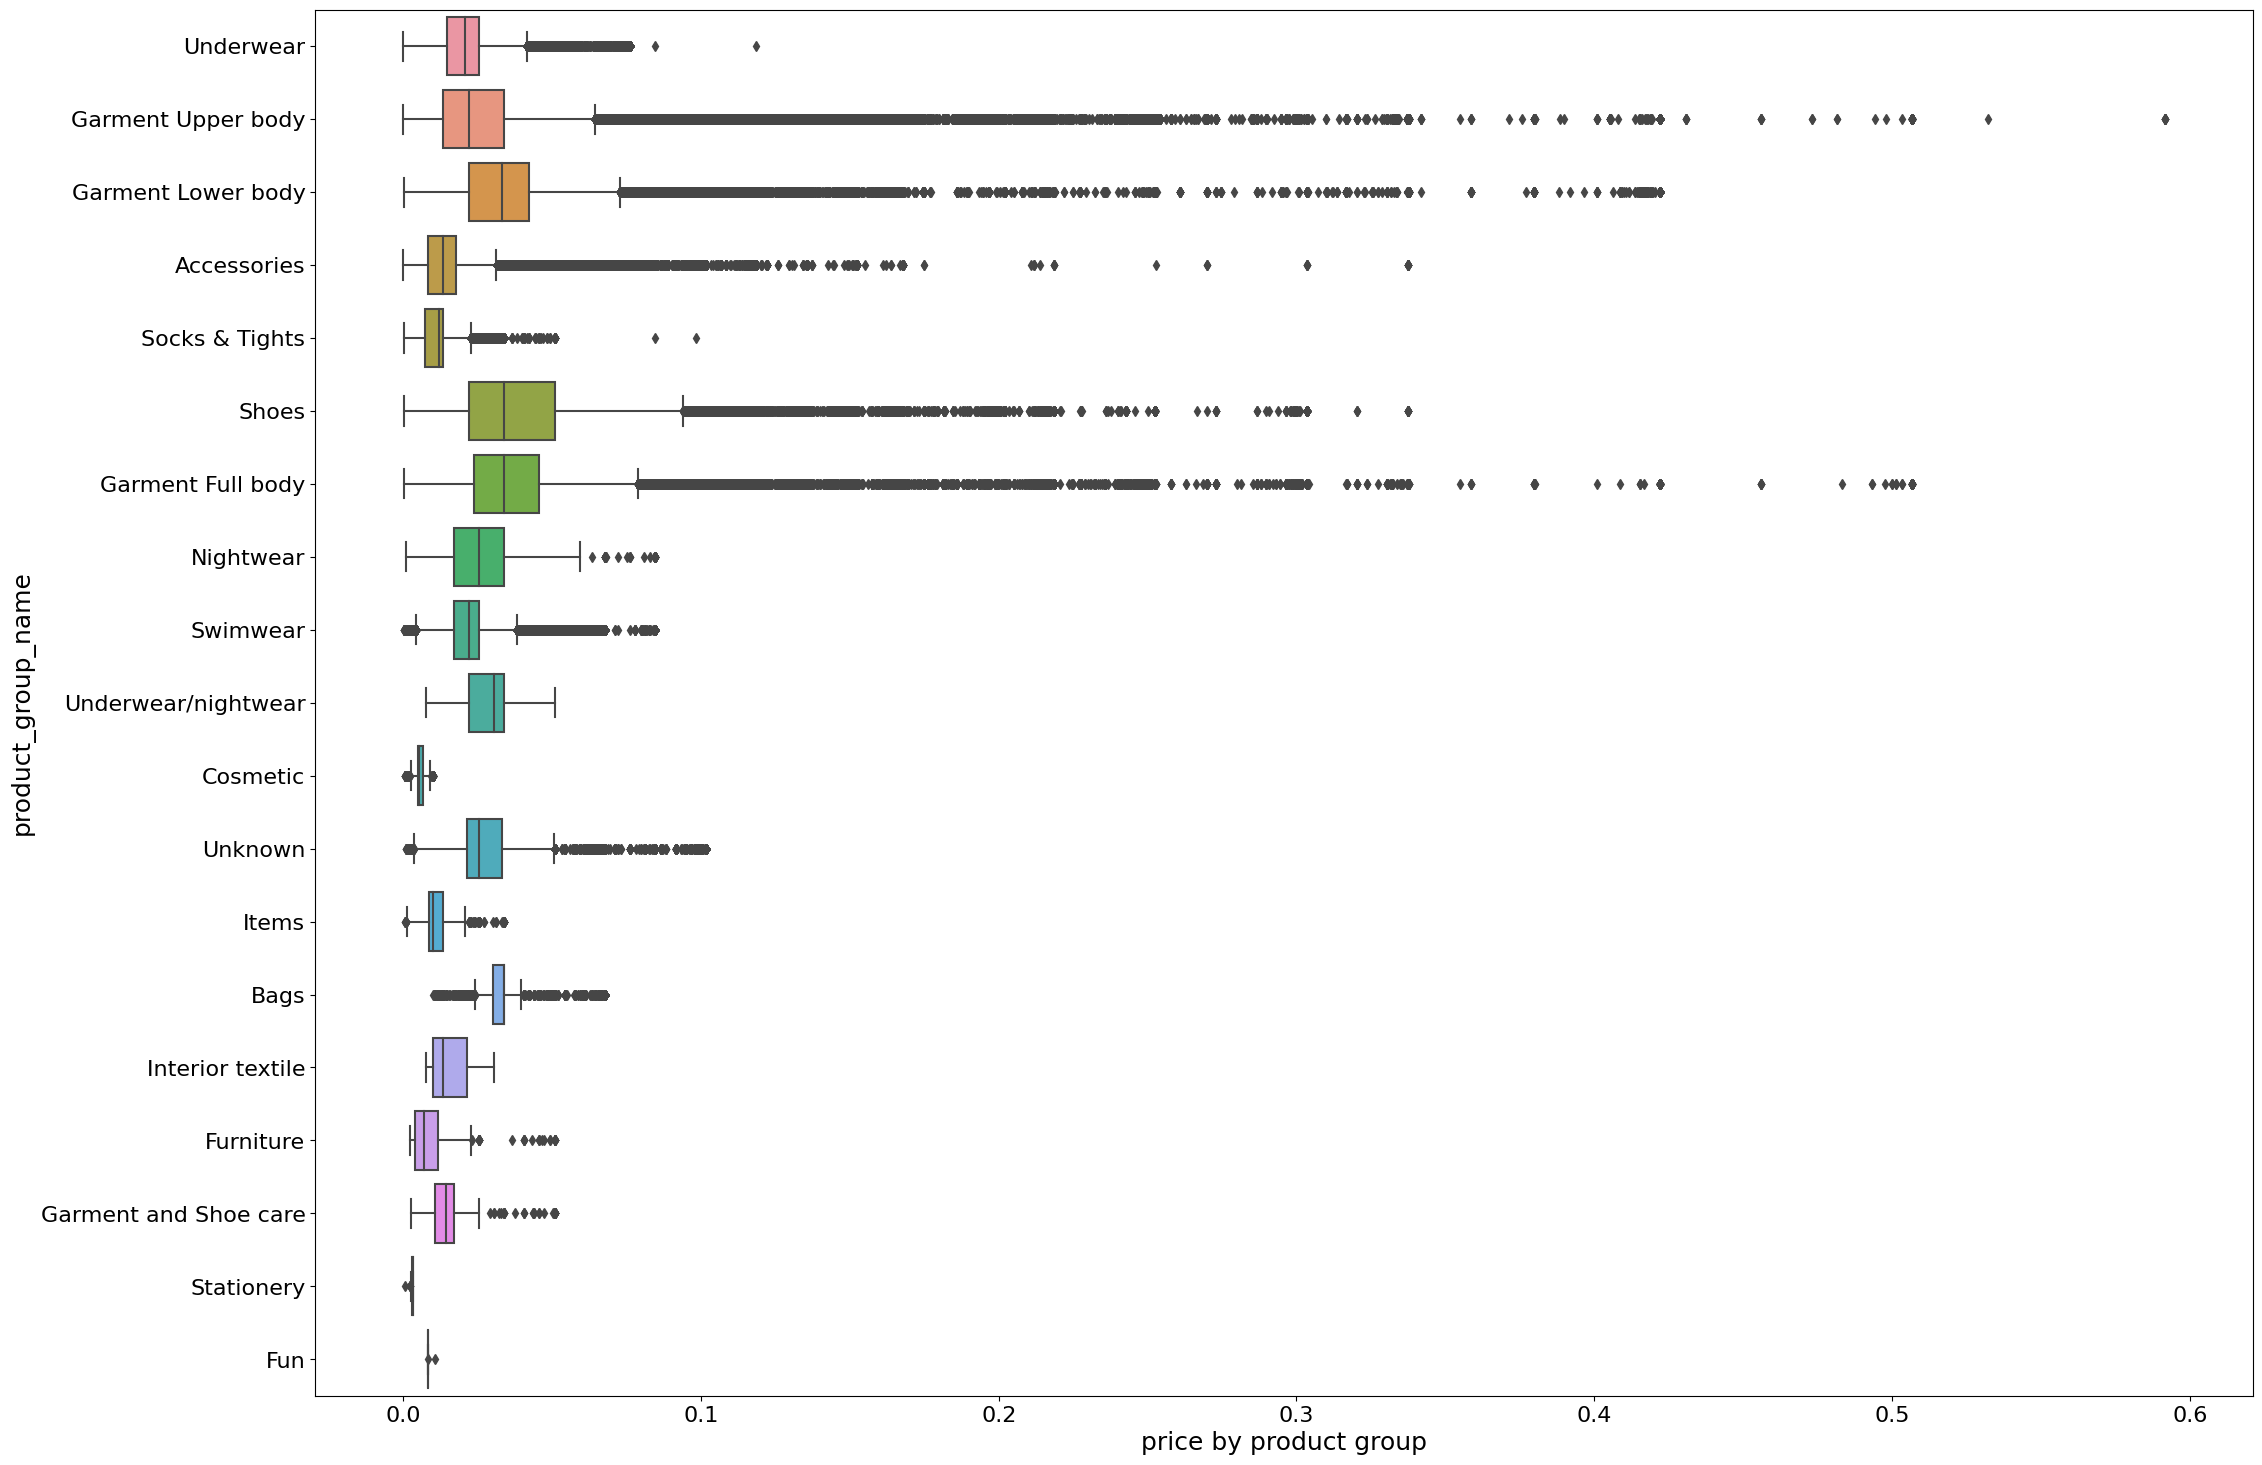

In [58]:
# Observing price distributions by product group 

# plot all boxplots
f, ax = plt.subplots(figsize=(25,18))
ax = sns.boxplot(data=merged_table_ta, x='price', y='product_group_name')
ax.set_xlabel('price by product group', fontsize=18)
ax.set_ylabel('product_group_name', fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

The prices for product groups Garment upper/lower/full and Shoes have a large variance in prices. The opposite is true for Cosmetic, Stationery and Fun product groups. <br> This is reasonable since the price can vary between different clothing collections of the same product group (Ex. premium full garmnet collection vs an on-sale garment collection).

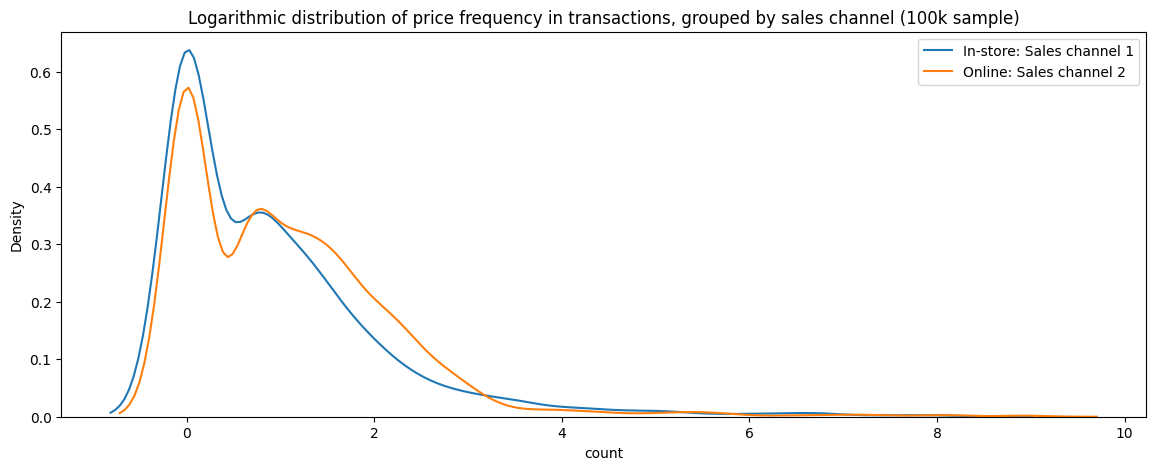

In [59]:
# Observing the distribution of price frequency in samples

# Sample 100,000 observations
merged_sample = merged_table_ta.sample(n=100000)

# using kdeplots to plot probability dist. of price values
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
sns.kdeplot(np.log(merged_sample.loc[merged_sample["sales_channel_id"]==1].price.value_counts()))
sns.kdeplot(np.log(merged_sample.loc[merged_sample["sales_channel_id"]==2].price.value_counts()))
ax.legend(labels=['In-store: Sales channel 1', 'Online: Sales channel 2'])
plt.title("Logarithmic distribution of price frequency in transactions, grouped by sales channel (100k sample)")
plt.show()


There is a slightly larger tendency for customers to purchase more expensive items online.

In [60]:
# Observing the top 10 customers by number of transactions

transactions['customer_id'].value_counts().head(10)

customer_id
 5854009424779598107    1895
 7398229172292340849    1441
 742206143892321423     1364
 3407358910964148684    1361
 1362310019195253974    1237
-4557035136527070563    1208
-4781325834093528838    1170
-6943172096873938826    1169
 1135991499650384534    1157
 8170076110479575893    1143
Name: count, dtype: int64

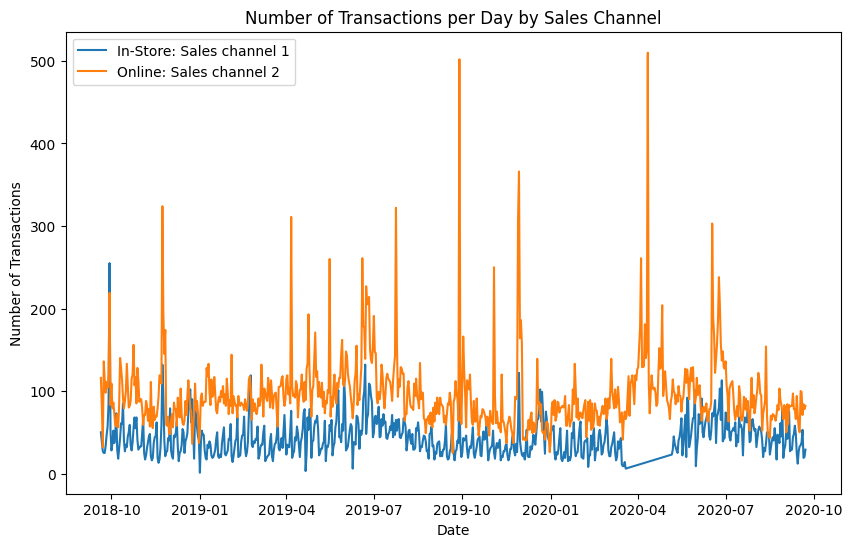

In [61]:
# Observing the number of transaction per day by sales channel

# Sample 100,000 observations
merged_table_ta_sample = merged_table_ta.sample(n=100000, random_state=69)

# Convert t_dat column to datetime format
merged_table_ta_sample['t_dat'] = pd.to_datetime(merged_table_ta_sample['t_dat'])

# Group the data by sales channel and date, and count the number of transactions for each group
transactions_by_day = merged_table_ta_sample.groupby(['sales_channel_id', pd.Grouper(key='t_dat', freq='D')])['article_id'].count()

# Create a line plot
fig, ax = plt.subplots(figsize=(10, 6))
for channel in transactions_by_day.index.levels[0]:
    if channel == 1:
        ax.plot(transactions_by_day[channel], label=f'In-Store: Sales channel 1')
    else:
        ax.plot(transactions_by_day[channel], label=f'Online: Sales channel 2')
ax.legend()
ax.set_title('Number of Transactions per Day by Sales Channel')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Transactions')
plt.show()


It is worth noting here that for April 2020, the number of in-store transactions is virtually nonexistent, while there is a sharp spike in online transactions for the same month; this is highly likely due to in-person stores possibly closing in April due to Covid-19.

In [62]:
num_unique_customers = len(transactions['customer_id'].unique())
num_unique_articles = len(transactions['article_id'].unique())
total_transactions = len(transactions)

print("Number of unique customers:", num_unique_customers)
print("Number of unique articles:", num_unique_articles)
print("Total number of transactions:", total_transactions)

Number of unique customers: 1362281
Number of unique articles: 104547
Total number of transactions: 31788324


## Models

Notes from the problem description:

"Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring."
    => `Predictions on 7 day period after the latest date found in the training data. The test week is the same for all customers, not one individual week per customer based on their latest training sample.`

- You will be making purchase predictions for all customer_id values provided, regardless of whether these customers made purchases in the training data.
- Customer that did not make any purchase during test period are excluded from the scoring.
- There is never a penalty for using the full 12 predictions for a customer that ordered fewer than 12 items; thus, it's advantageous to make 12 predictions for each customer.

-------------------------------------------------------------------------------------------------------------------------
As per the given evaluation metric `MAP@12`, since the rank = 12, we have to recommend the top 12 products (sorted by recommendation score), each cutsomer would purchase.

We will be using 1 baseline populuraity model and 4 different models that utilize `collaborative filtering` to make recommendations, and evaluate each model's performance using the MAP@12 metric. 

Since the dataset has no `explicit feedback` from customers (ex. ratings, reviews), we will consider the quantity of each item a customer purchased as an indicator of purchase preference - this will act as our `implicit feedback`. 

Additionally, one could also incorporate the price of an item as implicit feedback, as buying an expensive item could potentially be a stronger indicator of product preferences vs. buying large quantities of cheaper items. This is however something reserved for future work. 


### <a id="Popularity Model">4.1 Popularity Model</a>


To validate that the 4 models are all performing better than random chance, we will use the `popularity model` as a `baseline` model, which simply recommends `last week's top 12 items` to each customer. 

This will also be the model used to solved the `cold start` problem, where a customer who hasn't made any purchases yet is simply recommended the top 12 items. This may not be the most performant approach, but it is a practical approach given that fashion is seasonal and clothes/articles tend to go 'out of style' fairly quickly. This will also be used to fill up the 12 articles if other models cannot return 12 recommendations for a customer.

Other recommendation strategies suitable for solving the <br>
1.) cold start problem <br>
2.) situation where the customer has made less than 12 purchases <br>
3.) situation where the other models recommend less than 12 articles,<br> include: <br>

- recommend items previously purchased by the customer
- recommend items that are frequently bought together with the customer's previous purchase/s


In [63]:
# Test data is on 7-day period after latest_date in training data (week is same for all customers)

latest_transaction_date = transactions['t_dat'].max()
latest_transaction_date = pd.to_datetime(latest_transaction_date)
latest_transaction_date

Timestamp('2020-09-22 00:00:00')

In [64]:
# Getting the latest week's top 12 products

# Merge transactions with articles dataframe to get product names
transactions_with_names = pd.merge(transactions, articles[['article_id', 'prod_name']], on='article_id')

# Filter transactions to only include the latest week
transactions_with_names['t_dat'] = pd.to_datetime(transactions_with_names['t_dat'])
latest_week_transactions = transactions_with_names[transactions_with_names['t_dat'] >= latest_transaction_date - pd.Timedelta(days=7)]

# Get the top 12 products purchased during the latest week
latest_top_12_products = latest_week_transactions['article_id'].value_counts().head(12)

print("Last week's 12 most popular articles: \n")
print('{:<15}{:<30}{:<25}'.format('Article ID', 'Product Name', 'Purchases'))
print('-'*55)
for article_id, count in latest_top_12_products.items():
    prod_name = latest_week_transactions.loc[latest_week_transactions['article_id']==article_id, 'prod_name'].iloc[0]
    print('{:<15}{:<30}{:<25}'.format(article_id, prod_name, count))

Last week's 12 most popular articles: 

Article ID     Product Name                  Purchases                
-------------------------------------------------------
924243001      Ohlsson                       970                      
924243002      Ohlsson                       706                      
923758001      Vanessa                       705                      
918522001      Jackie cable vest             683                      
909370001      FF PI Haley dress             619                      
866731001      LANA seamless HW tigths       599                      
751471001      Pluto RW slacks (1)           584                      
915529003      Liliana                       554                      
915529005      Liliana                       542                      
448509014      Perrie Slim Mom Denim TRS     540                      
762846027      Lucy blouse                   538                      
714790020      Mom Fit Ultra HW              520    

### <a id="Alternating Least Squares">4.2 Alternating Least Squares</a>

In [68]:
import implicit
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
# import cudf
# import cupy as cp

In [ ]:
# for cleaner lookups

articles_lookup = articles[['article_id', 'prod_name']].drop_duplicates()
articles_lookup.head()

,article_id,prod_name
0,108775015,Strap top
1,108775044,Strap top
2,108775051,Strap top (1)
3,110065001,OP T-shirt (Idro)
4,110065002,OP T-shirt (Idro)


In [69]:
# --pandas version, slower

# Group transactions by customer_id and article_id, and count the number of purchases for each combination
customer_article_counts = transactions.groupby(['customer_id', 'article_id']).count()['price']

# Reset the index to convert the resulting Series to a DataFrame
customer_article_counts = customer_article_counts.reset_index()

# Rename the 'price' column to 'quantity'
customer_article_counts = customer_article_counts.rename(columns={'price': 'quantity'})

# Add the transaction date to the DataFrame
# customer_article_counts['t_dat'] = transactions['t_dat']

print("Aggregated purchases: \n")
aggr_purchases_matrix = customer_article_counts.copy()
print(aggr_purchases_matrix)
print("---")

print("Validating that no unpurchased articles are present for any customer: \n")
zero_purchases = customer_article_counts[customer_article_counts['quantity'] == 0].head(5)
print(zero_purchases)
print("---")

print(transactions.head(5))


Aggregated purchases: 

                  customer_id  article_id  quantity
0        -9223352921020755230   539723001         1
1        -9223352921020755230   568597006         1
2        -9223352921020755230   657510001         1
3        -9223352921020755230   673396002         1
4        -9223352921020755230   706016001         3
...                       ...         ...       ...
27306434  9223357421094039679   710900001         1
27306435  9223357421094039679   747984001         2
27306436  9223357421094039679   747984002         1
27306437  9223370729206611574   679525012         1
27306438  9223370729206611574   781758003         1

[27306439 rows x 3 columns]
---
Validating that no unpurchased articles are present for any customer: 

Empty DataFrame
Columns: [customer_id, article_id, quantity]
Index: []
---
        t_dat          customer_id  article_id  price  sales_channel_id
0  2018-09-20    -6846340800584936   663713001 0.0508                 2
1  2018-09-20    -6846340800

In [ ]:
# --cudf version, faster

# # User-item interaction matrix -> that stores number of times a customer purchases an article (all purchases > 0)

# # using cuDF
# transactions_cudf = cudf.from_pandas(transactions)

# # Group transactions by customer_id and article_id, and count the number of purchases for each combination
# customer_article_counts = transactions_cudf.groupby(['customer_id', 'article_id']).count()['price']

# customer_article_counts = customer_article_counts.reset_index()
# customer_article_counts['t_dat'] = transactions_cudf['t_dat']
# customer_article_counts = customer_article_counts.rename(columns={'price': 'quantity'})

# print("Aggregated purchases: \n")
# aggr_purchases_matrix = customer_article_counts.to_pandas()
# print(aggr_purchases_matrix)
# print("---")

# print("Validating that no unpurchased articles are present for any customer: \n")
# zero_purchases = customer_article_counts[customer_article_counts['quantity'] == 0].head(5)
# print(zero_purchases)
# print("---")

# print(transactions.head(5))

Aggregated purchases: 

                  customer_id  article_id  quantity       t_dat
0        -9223352921020755230   539723001         1  2018-09-20
1        -9223352921020755230   568597006         1  2018-09-20
2        -9223352921020755230   657510001         1  2018-09-20
3        -9223352921020755230   673396002         1  2018-09-20
4        -9223352921020755230   706016001         3  2018-09-20
...                       ...         ...       ...         ...
27306434  9223357421094039679   710900001         1  2020-06-16
27306435  9223357421094039679   747984001         2  2020-06-16
27306436  9223357421094039679   747984002         1  2020-06-16
27306437  9223370729206611574   679525012         1  2020-06-16
27306438  9223370729206611574   781758003         1  2020-06-16

[27306439 rows x 4 columns]
---
Validating that no unpurchased articles are present for any customer: 

Empty DataFrame
Columns: [customer_id, article_id, quantity, t_dat]
Index: []
---
        t_dat        

The purchase quantity can represent a "confidence" in terms of how strong the customer_id-article_id interaction is. <br> Articles with a larger number of purchases by a customer will thus carry more weight in our "ratings" matrix of purchases. (The rating == num. of purchases)

In [70]:
# --pandas version, slower

# Create a list of unique customer IDs and product IDs
uniq_customers = aggr_purchases_matrix.customer_id.unique()
uniq_customers.sort()
uniq_products = aggr_purchases_matrix.article_id.unique()
uniq_products.sort()

# Create a dictionary mapping customer IDs to their numerical indices in the sparse matrix
customer_index_dict = dict(zip(uniq_customers, range(len(uniq_customers))))

# Create a dictionary mapping product IDs to their numerical indices in the sparse matrix
product_index_dict = dict(zip(uniq_products, range(len(uniq_products))))

# Convert the customer and product IDs in the DataFrame to their numerical indices using the dictionaries
rows = aggr_purchases_matrix.customer_id.map(customer_index_dict)
cols = aggr_purchases_matrix.article_id.map(product_index_dict)

# Create the sparse ratings matrix
sparse_ratings_matrix = sparse.csr_matrix((aggr_purchases_matrix.quantity, (rows, cols)), shape=(len(uniq_customers), len(uniq_products)))
print(sparse_ratings_matrix[:1])


  (0, 10273)	1
  (0, 15965)	1
  (0, 38406)	1
  (0, 42514)	1
  (0, 53832)	3
  (0, 63431)	1
  (0, 81433)	1
  (0, 83305)	1
  (0, 91218)	1
  (0, 96975)	1


In [ ]:
# --cudf version, faster

# # Creating the sparse ratings matrix

# uniq_customers = list(np.sort(aggr_purchases_matrix.customer_id.unique())) 
# uniq_products = list(aggr_purchases_matrix.article_id.unique()) 
# quantity = list(aggr_purchases_matrix.quantity)

# # get row and cols indices

# # convert unique ids to categorical data -> then encode to numerical indices data (cuDF compatible code), a.k.a catgeorical encoding
# rows = aggr_purchases_matrix.customer_id.astype('category').cat.as_ordered().cat.codes
# cols = aggr_purchases_matrix.article_id.astype('category').cat.as_ordered().cat.codes

# sparse_ratings_matrix = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(uniq_customers), len(uniq_products)))
# sparse_ratings_matrix
# print(sparse_ratings_matrix[:1])

  (0, 10273)	1
  (0, 15965)	1
  (0, 38406)	1
  (0, 42514)	1
  (0, 53832)	3
  (0, 63431)	1
  (0, 81433)	1
  (0, 83305)	1
  (0, 91218)	1
  (0, 96975)	1


In the above sparse matrix output row: `(0, 10273)	1`: <br>
'0' corresponds to the index-encoded `customer_id` <br>
'10273' corresponds to the index-encoded `article_id` <br>
'1' corresponds to total number of purchases of '10273'<br>

Therefore, we have 1,362,281 unique customers and 104,547 unique articles (as seen previously). <br>
There are 27,306,439 interactions (purchases) stored 

In [71]:
# Calculating Sparsity of sparse_ratings_matrix

total_possible_interactions = sparse_ratings_matrix.shape[0]*sparse_ratings_matrix.shape[1] 
num_purchases = len(sparse_ratings_matrix.nonzero()[0]) 
sparsity = 100*(1 - (num_purchases/total_possible_interactions))
print("ratings matrix sparsity: ", sparsity)

ratings matrix sparsity:  99.98082714475392


<b>note: the current ratings matrix has 99.98% sparsity, and could thus affect the quality of recommendations.</b> <br>
all transactions sparsity: 99.98% <br>
1,000,000 transactions sparsity: 99.997% <br>
500,000 transactions sparsity: 99.997% <br>
100,000 transactions sparsity: 99.996% <br>

In [ ]:
# # splitting the transaction data into a testing and validation set based on transaction dates

# # Sort transactions by date
# sparse_ratings_matrix = sparse_ratings_matrix.sort_values('t_dat')
# split_index = int(0.8 * len(sparse_ratings_matrix))
# transactions_training_set = sparse_ratings_matrix[:split_index]
# transactions_val_set = sparse_ratings_matrix[split_index:]

# print("Number of transactions in training set:", len(transactions_training_set))
# print("Number of transactions in validation set:", len(transactions_val_set))

In [73]:
def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

In [74]:
# training and validation split
training_set, validation_set, article_users_altered = make_train(sparse_ratings_matrix, pct_test = 0.2)
print(training_set[:1])
print("---")
print(validation_set[:1])

  (0, 10273)	1
  (0, 15965)	1
  (0, 53832)	3
  (0, 63431)	1
  (0, 81433)	1
  (0, 83305)	1
  (0, 91218)	1
---
  (0, 10273)	1
  (0, 15965)	1
  (0, 38406)	1
  (0, 42514)	1
  (0, 53832)	1
  (0, 63431)	1
  (0, 81433)	1
  (0, 83305)	1
  (0, 91218)	1
  (0, 96975)	1


In [88]:
import logging
import implicit

# set logging level to DEBUG
logging.basicConfig(level=logging.DEBUG)

alpha = 15
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50, use_gpu=False)
mod = model.fit((training_set*alpha).astype('double'))


DEBUG:implicit:Calculated transpose in 0.259s
DEBUG:implicit:Initialized factors in 0.2982444763183594
DEBUG:implicit:Running 50 ALS iterations
100%|██████████| 50/50 [10:08<00:00, 12.18s/it]


In [86]:
print(mod)

In [89]:
x, y = mod
print(x)
print(y)


TypeError: cannot unpack non-iterable NoneType object